In [34]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.plot import show
import rasterio.mask as rmask
from rasterio.transform import array_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely import Polygon
from shapely import wkt
import ultraplot as uplt

In [35]:
arnot_forest = rio.open('./Data/StudySiteMaps/defol_eval_arnot_forest_2022.tif')
mt_pleasant = rio.open('./Data/StudySiteMaps/defol_eval_mt_pleasant_2021.tif')
allegheny = rio.open('./Data/StudySiteMaps/defol_eval_allegheny_2021.tif')
turkey_point = rio.open('./Data/StudySiteMaps/defol_eval_turkey_point_2021.tif')

In [37]:
dest_crs = ccrs.AlbersEqualArea(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs, mask_polygon=None):
    if mask_polygon is not None:
        orig_image, orig_transform = rmask.mask(raster_file, [mask_polygon], crop=True)
    else:
        orig_image = raster_file.read()
        orig_transform = raster_file.transform
        
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=orig_image,
        src_transform=orig_transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=np.nan)
    
    new_bounds = array_bounds(new_image.shape[1], new_image.shape[2], new_transform)
    #new_image = np.concatenate([new_image, new_image, new_image])
    new_image = new_image.transpose([1, 2, 0])

    # Rescale images to improve contrast
    minimum = 100
    maximum = 1000
    new_image[:, :, 0:6] = np.clip((new_image[:, :, 0:6] - minimum) / (maximum - minimum), 0, 1)
    
    # Create a nan mask
    alpha_channel = ~np.isnan(new_image[:, :, [0]])
    new_image = np.concatenate([new_image, alpha_channel], axis=2)

    return new_image, new_bounds

arnot_forest_reproj, arnot_forest_reproj_bounds = prepare_for_viz(arnot_forest, dest_crs)
mt_pleasant_reproj, mt_pleasant_reproj_bounds = prepare_for_viz(mt_pleasant, dest_crs)
allegheny_reproj, allegheny_reproj_bounds = prepare_for_viz(allegheny, dest_crs)
turkey_point_reproj, turkey_point_reproj_bounds = prepare_for_viz(turkey_point, dest_crs)

In [38]:
# Take an image, a nan color, and a palette for an integer valued array (expressed as 2-d array of color values)
def apply_palette(image, nan_color, palette):
    nan_image = np.tile(np.array([[[0, 0, 0, 0]]]), (image.shape[0], image.shape[1], 1))
    sanitized_image = np.nan_to_num(image).astype(int)
    
    nan_test = np.tile(np.isnan(image), (4, 1, 1)).transpose([1, 2, 0])
    return np.where(nan_test, nan_image, palette[sanitized_image])

In [39]:
def plot_defoliation(ax, image, crs, extent):
    # Add Defoliation classes to axes
    defol_palette = np.array([[0, 0, 0, 0],
                              [255, 0, 0, 255]])
    defol = apply_palette(image[:, :, 8], [0, 0, 0, 0], defol_palette)
    ax.imshow(defol, zorder=2, transform=crs, origin='upper',
              extent=extent)
    
def plot_landcover(ax, image, crs, extent):
    # Add Landcover to axes
    landcover_palette = np.array([[0, 0, 0, 0],
                                  [0, 0, 0, 255]])
    landcover = apply_palette(image[:, :, 9], [0, 0, 0, 0], landcover_palette)
    ax.imshow(landcover, zorder=3, transform=crs, origin='upper',
              extent=extent)

def plot_logging(ax, image, crs, extent):
    # Add Logging to axes
    logging_palette = np.array([[0, 0, 0, 0],
                                [0, 0, 255, 255]])
    logging = apply_palette(image[:, :, 10], [0, 0, 0, 0], logging_palette)
    ax.imshow(logging, zorder=2, transform=crs, origin='upper',
              extent=extent)

def plot_observations(ax, image, crs, extent):
    # Add Observations to axes
    obs_palette = np.array([[0, 0, 0, 0],
                            [0, 0, 255, 255]])
    obs = apply_palette(image[:, :, 11], [0, 0, 0, 0], obs_palette)
    ax.imshow(obs, zorder=2, transform=crs, origin='upper',
              extent=extent)

In [40]:
def plot_condition(ax, image, crs, extent):
    ax.imshow(image[:, :, [0, 1, 2, -1]], transform=crs, origin='upper',
              extent=extent)
    plot_defoliation(ax, image, crs, extent)
    plot_landcover(ax, image, crs, extent)
    plot_logging(ax, image, crs, extent)
    plot_observations(ax, image, crs, extent)    
    ax.set_extent(extent, crs=crs)

def plot_condition_v2(ax, image, crs, extent):
    plot_defoliation(ax, image, crs, extent)
    plot_landcover(ax, image, crs, extent)
    plot_logging(ax, image, crs, extent)
    plot_observations(ax, image, crs, extent)    
    ax.set_extent(extent, crs=crs)

In [41]:
def add_scalebar(ax, scale_length):
    scalebar = AnchoredSizeBar(ax.transData,
                           scale_length, f'{scale_length//1000} km', 'upper right', 
                           pad=0.3,
                           sep=3,
                           color='black',
                           frameon=True,
                           size_vertical=1,
                           label_top=True)
    ax.add_artist(scalebar)

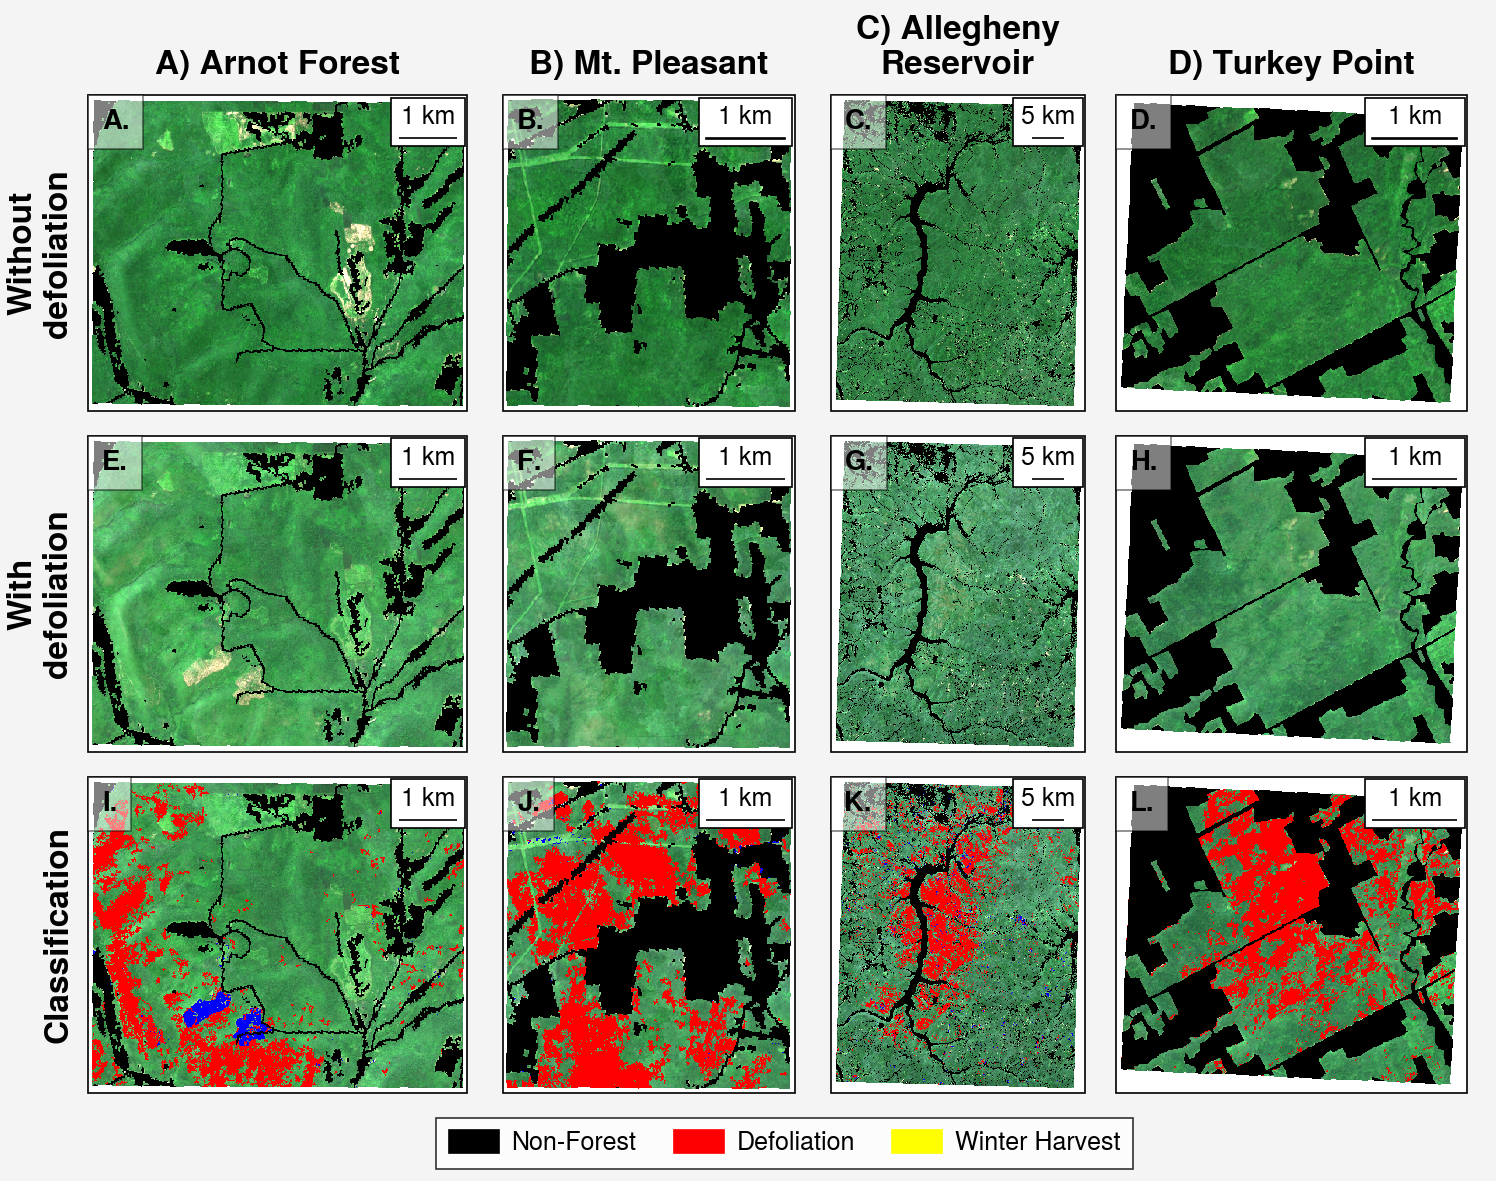

In [44]:
fig, axes = uplt.subplots(ncols=4, nrows=3, share=False, proj=dest_crs, figsize=('190mm', '150mm'), wspace=(-0.5, -3,-2))


# Arnot Forest
af_extent = [arnot_forest_reproj_bounds[0], arnot_forest_reproj_bounds[2], arnot_forest_reproj_bounds[1], arnot_forest_reproj_bounds[3]]
axes[0].imshow(arnot_forest_reproj[:, :, [3, 4, 5, -1]], transform=dest_crs,
               extent=af_extent)
plot_landcover(axes[0], arnot_forest_reproj, dest_crs, af_extent)
axes[0].set_extent(af_extent, crs=dest_crs)
axes[4].imshow(arnot_forest_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs,
               extent=af_extent)
plot_landcover(axes[4], arnot_forest_reproj, dest_crs, af_extent)
axes[4].set_extent(af_extent, crs=dest_crs)
plot_condition(axes[8], arnot_forest_reproj, dest_crs, af_extent)
add_scalebar(axes[0], 1000)
add_scalebar(axes[4], 1000)
add_scalebar(axes[8], 1000)


# Mt. Pleasant
mp_extent = [mt_pleasant_reproj_bounds[0], mt_pleasant_reproj_bounds[2], mt_pleasant_reproj_bounds[1], mt_pleasant_reproj_bounds[3]]
axes[1].imshow(mt_pleasant_reproj[:, :, [3, 4, 5, -1]], transform=dest_crs,
               extent=mp_extent)
plot_landcover(axes[1], mt_pleasant_reproj, dest_crs, mp_extent)
axes[1].set_extent(mp_extent, crs=dest_crs)
axes[5].imshow(mt_pleasant_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs,
               extent=mp_extent)
plot_landcover(axes[5], mt_pleasant_reproj, dest_crs, mp_extent)
axes[5].set_extent(mp_extent, crs=dest_crs)
plot_condition(axes[9], mt_pleasant_reproj, dest_crs,
               mp_extent)
add_scalebar(axes[1], 1000)
add_scalebar(axes[5], 1000)
add_scalebar(axes[9], 1000)

# Allegheny
al_extent = [allegheny_reproj_bounds[0], allegheny_reproj_bounds[2], allegheny_reproj_bounds[1], allegheny_reproj_bounds[3]]
axes[2].imshow(allegheny_reproj[:, :, [3, 4, 5, -1]], transform=dest_crs,
               extent=al_extent)
plot_landcover(axes[2], allegheny_reproj, dest_crs, al_extent)
axes[2].set_extent(al_extent, crs=dest_crs)
axes[6].imshow(allegheny_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs,
               extent=al_extent)
plot_landcover(axes[6], allegheny_reproj, dest_crs, al_extent)
axes[6].set_extent(al_extent, crs=dest_crs)
plot_condition(axes[10], allegheny_reproj, dest_crs, al_extent)
add_scalebar(axes[2], 5000)
add_scalebar(axes[6], 5000)
add_scalebar(axes[10], 5000)

# Turkey Point
tp_extent = [turkey_point_reproj_bounds[0], turkey_point_reproj_bounds[2], turkey_point_reproj_bounds[1], turkey_point_reproj_bounds[3]]
axes[3].imshow(turkey_point_reproj[:, :, [3, 4, 5, -1]], transform=dest_crs,
               extent=tp_extent)
plot_landcover(axes[3], turkey_point_reproj, dest_crs, tp_extent)
axes[3].set_extent(tp_extent, crs=dest_crs)
axes[7].imshow(turkey_point_reproj[:, :, [0, 1, 2, -1]], transform=dest_crs,
               extent=tp_extent)
plot_landcover(axes[7], turkey_point_reproj, dest_crs, tp_extent)
axes[7].set_extent(tp_extent, crs=dest_crs)
plot_condition(axes[11], turkey_point_reproj, dest_crs,
               tp_extent)
add_scalebar(axes[3], 1000)
add_scalebar(axes[7], 1000)
add_scalebar(axes[11], 1000)


axes.format(
    toplabels=('Arnot Forest', 'Mt. Pleasant', 'Allegheny\nReservoir', 'Turkey Point'),
    toplabels_kw={'size':'12', 'ha':'center'},
    leftlabels=('Without\ndefoliation', 
                'With\ndefoliation', 
                'Classification'),
    leftlabels_kw={'size':'12', 'ma':'center'},
    abc='A.', abcloc='ul', abcbbox=True)

# Create legend
landcover_patch = mpatches.Patch(color=[0,0,0], label='Non-Forest')
defol_patch = mpatches.Patch(color=[1,0,0], label='Defoliation')
logging_patch = mpatches.Patch(color=[1,1,0], label='Winter Harvest')
obs_patch = mpatches.Patch(color=[0,0,1], label='Insufficient Observations')
fig.legend(handles=[landcover_patch, defol_patch, logging_patch], loc='b', ncols=4)


#fig.savefig('./Figures/StudySiteMaps/study_site_comparison.png')

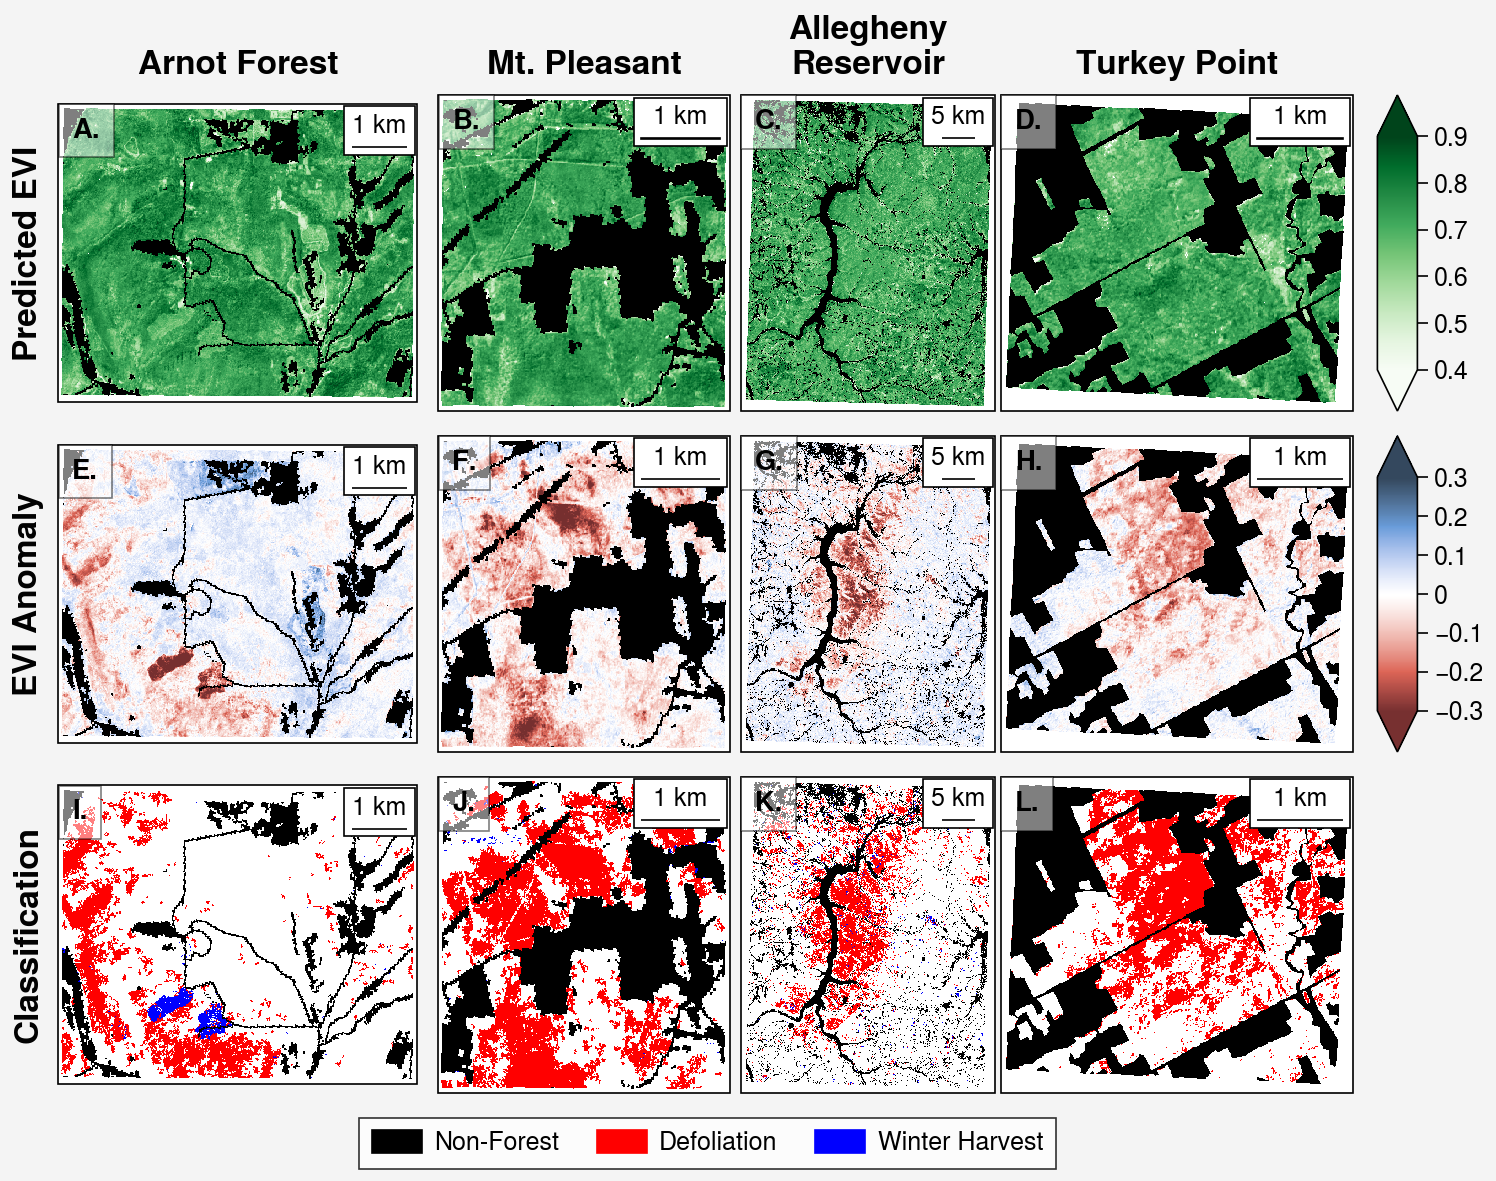

In [45]:
# Add scalebar
fig, axes = uplt.subplots(ncols=4, nrows=3, share=False, proj=dest_crs, figsize=('190mm', '150mm'), wspace=(-0.5, -3,-2))

evi_vmin = 0.4
evi_vmax = 0.9
anom_vmin = -0.3
anom_vmax = 0.3

# Arnot Forest
af_extent = [arnot_forest_reproj_bounds[0], arnot_forest_reproj_bounds[2], arnot_forest_reproj_bounds[1], arnot_forest_reproj_bounds[3]]
m = axes[0].imshow(arnot_forest_reproj[:, :, 6], transform=dest_crs,
               extent=af_extent, vmin=evi_vmin, vmax=evi_vmax, cmap='greens')
plot_landcover(axes[0], arnot_forest_reproj, dest_crs, af_extent)
axes[0].set_extent(af_extent, crs=dest_crs)
n = axes[4].imshow(arnot_forest_reproj[:, :, 7], transform=dest_crs,
               extent=af_extent, vmin=anom_vmin, vmax=anom_vmax, cmap='negpos_r')
plot_landcover(axes[4], arnot_forest_reproj, dest_crs, af_extent)
axes[4].set_extent(af_extent, crs=dest_crs)
plot_condition_v2(axes[8], arnot_forest_reproj, dest_crs, af_extent)
add_scalebar(axes[0], 1000)
add_scalebar(axes[4], 1000)
add_scalebar(axes[8], 1000)

# Mt. Pleasant
mp_extent = [mt_pleasant_reproj_bounds[0], mt_pleasant_reproj_bounds[2], mt_pleasant_reproj_bounds[1], mt_pleasant_reproj_bounds[3]]
axes[1].imshow(mt_pleasant_reproj[:, :, 6], transform=dest_crs,
               extent=mp_extent, vmin=evi_vmin, vmax=evi_vmax, cmap='greens')
plot_landcover(axes[1], mt_pleasant_reproj, dest_crs, mp_extent)
axes[1].set_extent(mp_extent, crs=dest_crs)
axes[5].imshow(mt_pleasant_reproj[:, :, 7], transform=dest_crs,
               extent=mp_extent, vmin=anom_vmin, vmax=anom_vmax, cmap='negpos_r')
plot_landcover(axes[5], mt_pleasant_reproj, dest_crs, mp_extent)
axes[5].set_extent(mp_extent, crs=dest_crs)
plot_condition_v2(axes[9], mt_pleasant_reproj, dest_crs, mp_extent)
add_scalebar(axes[1], 1000)
add_scalebar(axes[5], 1000)
add_scalebar(axes[9], 1000)

# Allegheny
al_extent = [allegheny_reproj_bounds[0], allegheny_reproj_bounds[2], allegheny_reproj_bounds[1], allegheny_reproj_bounds[3]]
axes[2].imshow(allegheny_reproj[:, :, 6], transform=dest_crs,
               extent=al_extent, vmin=evi_vmin, vmax=evi_vmax, cmap='greens')
plot_landcover(axes[2], allegheny_reproj, dest_crs, al_extent)
axes[2].set_extent(al_extent, crs=dest_crs)
axes[6].imshow(allegheny_reproj[:, :, 7], transform=dest_crs,
               extent=al_extent, vmin=anom_vmin, vmax=anom_vmax, cmap='negpos_r')
plot_landcover(axes[6], allegheny_reproj, dest_crs, al_extent)
axes[6].set_extent(al_extent, crs=dest_crs)
plot_condition_v2(axes[10], allegheny_reproj, dest_crs, al_extent)
add_scalebar(axes[2], 5000)
add_scalebar(axes[6], 5000)
add_scalebar(axes[10], 5000)

# Turkey Point
tp_extent = [turkey_point_reproj_bounds[0], turkey_point_reproj_bounds[2], turkey_point_reproj_bounds[1], turkey_point_reproj_bounds[3]]
axes[3].imshow(turkey_point_reproj[:, :, 6], transform=dest_crs,
               extent=tp_extent, vmin=evi_vmin, vmax=evi_vmax, cmap='greens')
plot_landcover(axes[3], turkey_point_reproj, dest_crs, tp_extent)
axes[3].set_extent(tp_extent, crs=dest_crs)
axes[7].imshow(turkey_point_reproj[:, :, 7], transform=dest_crs,
               extent=tp_extent, vmin=anom_vmin, vmax=anom_vmax, cmap='negpos_r')
plot_landcover(axes[7], turkey_point_reproj, dest_crs, tp_extent)
axes[7].set_extent(tp_extent, crs=dest_crs)
plot_condition_v2(axes[11], turkey_point_reproj, dest_crs, tp_extent)
add_scalebar(axes[3], 1000)
add_scalebar(axes[7], 1000)
add_scalebar(axes[11], 1000)

axes.format(
    toplabels=('Arnot Forest', 'Mt. Pleasant', 'Allegheny\nReservoir', 'Turkey Point'),
    toplabels_kw={'size':'12', 'ha':'center'},
    leftlabels=('Predicted EVI', 
                'EVI Anomaly', 
                'Classification'),
    leftlabels_kw={'size':'12', 'ma':'center'},
    abc='A.', abcloc='ul', abcbbox=True)

# Add colorbars
fig.colorbar(m, loc="r", row=1, locator=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9], minorlocator=[], extend='both')
fig.colorbar(n, loc="r", row=2, locator=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3], minorlocator=[], extend='both')

# Create legend
landcover_patch = mpatches.Patch(color=[0,0,0], label='Non-Forest')
defol_patch = mpatches.Patch(color=[1,0,0], label='Defoliation')
logging_patch = mpatches.Patch(color=[0,0,1], label='Winter Harvest')
obs_patch = mpatches.Patch(color=[0,0,1], label='Insufficient Observations')
fig.legend(handles=[landcover_patch, defol_patch, logging_patch], loc='b', ncols=4)

fig.savefig('./Figures/StudySiteMaps/study_site_comparison_v2.png')

In [ ]:
fig, axes = uplt.subplots(ncols=1, nrows=1, share=False, proj=dest_crs, fontsize=12, figsize=('190mm', '150mm'))
tp_extent = [turkey_point_reproj_bounds[0], turkey_point_reproj_bounds[2], turkey_point_reproj_bounds[1], turkey_point_reproj_bounds[3]]
# axes[0].imshow(turkey_point_reproj[:, :, [3, 4, 5, -1]], transform=dest_crs,
#                extent=tp_extent)
#axes[0].imshow(turkey_point_reproj[:, :, 10], vmin=0, vmax = 1)
plot_landcover(axes[0], turkey_point_reproj, dest_crs, tp_extent)
axes[0].set_extent(tp_extent, crs=dest_crs)

In [25]:
def plot_landcover(ax, image, crs, extent):
    # Add Landcover to axes
    landcover_palette = np.array([[0, 0, 0, 0],
                                  [0, 0, 0, 255]])
    landcover = apply_palette(image[:, :, 11], [0, 0, 0, 0], landcover_palette)
    ax.imshow(landcover, zorder=3, transform=crs, origin='upper',
              extent=extent)